In [2]:
import fitz
import pandas as pd
import numpy as np
from tabula import read_pdf

In [3]:
# Path to the PDF file
pdf_path = 'timetable.pdf'

# Get number of pages

In [4]:
# get number of pages

doc = fitz.open(pdf_path)
num_pages = len(doc)
doc.close()

# Reading tables

In [5]:
tables = read_pdf(pdf_path, pages='all', multiple_tables=True)

# Removing headers for first df

In [6]:
#Removing headers
def remove_header(df):
    header_row_index = df[df.iloc[:, 0] == 'COM COD'].index[0]
    df = df.drop(index=df.index[:header_row_index]).reset_index(drop=True)
    df.columns = df.iloc[0]
    df = df.drop(index=0).reset_index(drop=True)
    
    return df


# Instructors-in-charge

In [7]:
def is_uppercase(s):
    return s == s.upper()

In [129]:
def instructors(df):
    instructors_in_charge = df[df['INSTRUCTOR-IN-CHARGE/ Instructor'].apply(is_uppercase)]    
    return instructors_in_charge

# Fill Linearly

In [8]:
def forward_fill_course_details(df):
    df['COURSE TITLE'].fillna(method='ffill', inplace=True)
    df['COURSE NO.'].fillna(method='ffill', inplace=True)
    df['CREDIT\rL P U'].fillna(method='ffill', inplace=True)
    return df


# Laboratories

In [131]:
def has_lab(s):
    if 'LABORATORY' in s and 'PROJECT' not in s:
        return True
    else:
        return False

In [132]:
def is_not_uppercase(s):
    return not s.isupper()

In [133]:
def lab(df):    
    laboratories = df[df['COURSE TITLE'].apply(has_lab)]
    # laboratories = laboratories.drop(['MIDSEM TEST', 'COMRE DATE &\rSESSION'], axis=1)
    laboratories = laboratories[laboratories['INSTRUCTOR-IN-CHARGE/ Instructor'].apply(is_not_uppercase)]
    
    return laboratories

# Dataframes based on number of tables

Iterate through number of pages, and merge the dfs together

In [9]:
df = remove_header(tables[0])
column_names = df.columns

for i in range(1, num_pages):
    temp_df = tables[i]
    temp_df.columns = column_names
    df = pd.concat([df, temp_df], ignore_index=True)

In [10]:
df.columns

Index(['COM COD', 'COURSE NO.', 'COURSE TITLE', 'CREDIT\rL P U', 'SEC',
       'INSTRUCTOR-IN-CHARGE/ Instructor', 'ROOM', 'DAYS/  HOURS',
       'MIDSEM TEST', 'COMRE DATE &\rSESSION'],
      dtype='object', name=0)

In [11]:
df = df.drop('COM COD', axis = 1)

Linearly filling

In [12]:
df = forward_fill_course_details(df)

Getting instructor-in-charge df

In [13]:
instructors_in_charge = instructors(df)

NameError: name 'instructors' is not defined

Laboratory

In [ ]:
laboratories = lab(df)

Removing classes which don't have time slots assigned

In [14]:
df = df.dropna(subset=['DAYS/  HOURS'])

In [15]:
df['COURSE NO.'].unique()

array(['AN F311', 'BIO F110', 'BIO F111', 'BIOT F241', 'BIOT F243',
       'BIOT F244', 'BIOT F245', 'BIOT F342', 'BIOT F344', 'BIOT F417',
       'BIOT F423', 'BIOT F422', 'BITS F462', 'BITS F110', 'BITS F111',
       'BITS F112', 'BITS F225', 'BITS F312', 'BITS F416', 'BITS F452',
       'BITS F464', 'CE F241', 'CE F242', 'CE F244', 'CE F321', 'CE F342',
       'CE F343', 'CE F415', 'CE F423', 'CHE F241', 'CHE F242',
       'CHE F243', 'CHE F244', 'CHE F341', 'CHE F342', 'CHE F343',
       'CHE F414', 'CHE F416', 'CHEM F110', 'CHEM F111', 'CS F111',
       'CS F211', 'CS F212', 'CS F241', 'CS F303', 'CS F320', 'CS F363',
       'CS F364', 'CS F407', 'CS F415', 'CS F425', 'CS F429', 'ECE F241',
       'ECE F242', 'ECE F243', 'ECE F244', 'ECE F266', 'ECE F343',
       'ECE F344', 'ECE F432', 'ECE F472', 'ECON F211', 'ECON F312',
       'ECON F412', 'EEE F111', 'EEE F241', 'EEE F242', 'EEE F243',
       'EEE F244', 'EEE F341', 'EEE F342', 'EEE F417', 'EEE F472',
       'FIN F212', 'FIN 

# Parsing Days and Hours

Time slots with timings

In [16]:
import pandas as pd

time_slots = {
    'Monday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00', '12:05-12:55', '1:00-1:50', '1:55-2:45', '2:50-3:40'],
    'Tuesday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00', '12:05-12:55', '1:00-1:50', '1:55-2:45', '2:50-3:40'],
    'Wednesday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00', '12:05-12:55', '1:00-1:50', '1:55-2:45', '2:50-3:40'],
    'Thursday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00', '12:05-12:55', '1:00-1:50', '1:55-2:45', '2:50-3:40'],
    'Friday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00'],
}

def map_days_hours_to_time_slots(day_hour_str):
    days = {'M': 'Monday', 'T': 'Tuesday', 'W': 'Wednesday', 'Th': 'Thursday', 'F': 'Friday', 'S': 'Saturday', 'Su': 'Sunday'}
    day_hour_list = []
    day_str = ''
    hour_str = ''
    for char in day_hour_str:
        if char.isalpha():
            if day_str and hour_str:
                day = days.get(day_str, "Unknown Day")
                for hour in hour_str:
                    slot = time_slots[day][int(hour)-1]
                    day_hour_list.append((day, slot))
                day_str = ''
                hour_str = ''
            day_str += char
        elif char.isdigit():
            hour_str += char
    if day_str and hour_str:
        day = days.get(day_str, "Unknown Day")
        for hour in hour_str:
            slot = time_slots[day][int(hour)-1]
            day_hour_list.append((day, slot))
    return day_hour_list


df['TIME SLOTS'] = df['DAYS/  HOURS'].apply(map_days_hours_to_time_slots)
df

,COURSE NO.,COURSE TITLE,CREDIT\rL P U,SEC,INSTRUCTOR-IN-CHARGE/ Instructor,ROOM,DAYS/ HOURS,MIDSEM TEST,COMRE DATE &\rSESSION,TIME SLOTS
0,AN F311,PRINCIPLES OF AERODYNAMICS,3 0 3,1,MAJID H KHAN,276,M6 T2 F1,03.04.2024 FN,04.06.2024 AN,"[(Monday, 12:05-12:55), (Tuesday, 8:25-9:15), ..."
2,BIO F110,BIOLOGY LABORATORY,0 2 1,1,Aditya Sharma,307,M34,NaN,NaN,"[(Monday, 9:20-10:10), (Monday, 10:15-11:05)]"
3,BIO F110,BIOLOGY LABORATORY,0 2 1,2,Neeru Sood,307,M89,NaN,NaN,"[(Monday, 1:55-2:45), (Monday, 2:50-3:40)]"
4,BIO F110,BIOLOGY LABORATORY,0 2 1,3,Debostuti Ghosh,307,T34,NaN,NaN,"[(Tuesday, 9:20-10:10), (Tuesday, 10:15-11:05)]"
5,BIO F110,BIOLOGY LABORATORY,0 2 1,4,Neeru Sood,307,W12,NaN,NaN,"[(Wednesday, 7:30-8:20), (Wednesday, 8:25-9:15)]"
...,...,...,...,...,...,...,...,...,...,...
305,PHY F110,PHYSICS LABORATORY,0 2 1,8,Amarnath,309.0,Th89,NaN,NaN,"[(Thursday, 1:55-2:45), (Thursday, 2:50-3:40)]"
306,PHY F111,MECH OSCILLATIONS & WAVE,3 0 3,1,AMARNATH,165.0,M6 T1 Th6 F2,01.04.2024 FN,04.06.2024 FN,"[(Monday, 12:05-12:55), (Tuesday, 7:30-8:20), ..."
307,PHY F111,MECH OSCILLATIONS & WAVE,3 0 3,2,R Roopkumar,183.0,M6 T1 Th6 F2,NaN,NaN,"[(Monday, 12:05-12:55), (Tuesday, 7:30-8:20), ..."
308,PHY F111,MECH OSCILLATIONS & WAVE,3 0 3,3,K K Singh,190.0,M6 T8 W1 F2,NaN,NaN,"[(Monday, 12:05-12:55), (Tuesday, 1:55-2:45), ..."


# Time slots as numbers

In [95]:
import pandas as pd

time_slots = {
    'Monday': ['1','2','3','4','5','6','7','8','9'],
    'Tuesday': ['1','2','3','4','5','6','7','8','9'],
    'Wednesday': ['1','2','3','4','5','6','7','8','9'],
    'Thursday': ['1','2','3','4','5','6','7','8','9'],
    'Friday': ['1','2','3','4','5']
}

def map_days_hours_to_time_slots(day_hour_str):
    days = {'M': 'Monday', 'T': 'Tuesday', 'W': 'Wednesday', 'Th': 'Thursday', 'F': 'Friday', 'S': 'Saturday', 'Su': 'Sunday'}
    day_hour_list = []
    day_str = ''
    hour_str = ''
    for char in day_hour_str:
        if char.isalpha():
            if day_str and hour_str:
                day = days.get(day_str, "Unknown Day")
                for hour in hour_str:
                    slot = time_slots[day][int(hour)-1]
                    day_hour_list.append((day, slot))
                day_str = ''
                hour_str = ''
            day_str += char
        elif char.isdigit():
            hour_str += char
    if day_str and hour_str:
        day = days.get(day_str, "Unknown Day")
        for hour in hour_str:
            slot = time_slots[day][int(hour)-1]
            day_hour_list.append((day, slot))
    return day_hour_list


df['TIME SLOTS'] = df['DAYS/  HOURS'].apply(map_days_hours_to_time_slots)
df

,COURSE NO.,COURSE TITLE,CREDIT\rL P U,SEC,INSTRUCTOR-IN-CHARGE/ Instructor,ROOM,DAYS/ HOURS,MIDSEM TEST,COMRE DATE &\rSESSION,TIME SLOTS
0,AN F311,PRINCIPLES OF AERODYNAMICS,3 0 3,1,MAJID H KHAN,276,M6 T2 F1,03.04.2024 FN,04.06.2024 AN,"[(Monday, 6), (Tuesday, 2), (Friday, 1)]"
2,NaN,NaN,NaN,1,Aditya Sharma,307,M34,NaN,NaN,"[(Monday, 3), (Monday, 4)]"
3,NaN,NaN,NaN,2,Neeru Sood,307,M89,NaN,NaN,"[(Monday, 8), (Monday, 9)]"
4,NaN,NaN,NaN,3,Debostuti Ghosh,307,T34,NaN,NaN,"[(Tuesday, 3), (Tuesday, 4)]"
5,NaN,NaN,NaN,4,Neeru Sood,307,W12,NaN,NaN,"[(Wednesday, 1), (Wednesday, 2)]"
...,...,...,...,...,...,...,...,...,...,...
305,NaN,NaN,NaN,8,Amarnath,309.0,Th89,NaN,NaN,"[(Thursday, 8), (Thursday, 9)]"
306,PHY F111,MECH OSCILLATIONS & WAVE,3 0 3,1,AMARNATH,165.0,M6 T1 Th6 F2,01.04.2024 FN,04.06.2024 FN,"[(Monday, 6), (Tuesday, 1), (Thursday, 6), (Fr..."
307,NaN,NaN,NaN,2,R Roopkumar,183.0,M6 T1 Th6 F2,NaN,NaN,"[(Monday, 6), (Tuesday, 1), (Thursday, 6), (Fr..."
308,NaN,NaN,NaN,3,K K Singh,190.0,M6 T8 W1 F2,NaN,NaN,"[(Monday, 6), (Tuesday, 8), (Wednesday, 1), (F..."


# Trial 1 - Ignore

In [ ]:
from constraint import Problem
import re

compulsory_df = df[df['COURSE NO.'].isin(third_year_second_semester_requirements)]


problem = Problem()

def has_practical(credit_str):
    match = re.match(r"(\d) 1 \1", credit_str)  # Adjusted to match the format "x 1 x+1" where x is any integer
    return bool(match)

def no_overlap(*args):
    # Flatten the list of all time slots received from multiple arguments
    all_time_slots = [time_slot for arg in args for time_slot in arg]
    
    # Convert each time slot into a more detailed structure for comparison
    detailed_slots = []
    for day, times in all_time_slots:
        start_time, end_time = times.split("-")
        start_hour, start_minute = map(int, start_time.split(":"))
        end_hour, end_minute = map(int, end_time.split(":"))
        detailed_slots.append((day, start_hour, start_minute, end_hour, end_minute))
    
    # Check for overlap
    for i, slot1 in enumerate(detailed_slots):
        for slot2 in detailed_slots[i+1:]:
            if slot1[0] == slot2[0]:  # Same day
                if not (slot1[3] < slot2[1] or slot1[1] > slot2[3]):  # Check if times don't overlap
                    return False  # Overlap found
    return True  # No overlaps detected



for course in third_year_second_semester_requirements:
    course_sections = compulsory_df[compulsory_df['COURSE NO.'] == course]
    
    lecture_sections = [(row['SEC'], row['TIME SLOTS']) for index, row in course_sections.iterrows()]
    problem.addVariable(course, lecture_sections)
    
    if any(has_practical(row['CREDIT\rL P U']) for index, row in course_sections.iterrows()):
        practical_sections = [(f"{row['SEC']} Practical", row['TIME SLOTS']) for index, row in course_sections.iterrows()]
        problem.addVariable(f"{course} Practical", practical_sections)

all_courses = list(third_year_second_semester_requirements) + [f"{course} Practical" for course in third_year_second_semester_requirements if any(has_practical(row['CREDIT\rL P U']) for index, row in compulsory_df[compulsory_df['COURSE NO.'] == course].iterrows())]
problem.addConstraint(no_overlap, all_courses)

solutions = problem.getSolutions()

if solutions:
    print("A possible schedule without clashes:")
    for key, value in solutions[0].items():
        course, section = value
        print(f"{key}: Section {section}")
else:
    print("No possible schedule found that satisfies all constraints.")


# Way ahead
1. Distinguish between lectures and practicals: Based on the 'COURSE TITLE', distinguish lectures from their corresponding practical sessions.
2. Create separate constraints for lectures and practicals: Since each student must be enrolled in both a lecture and a practical session (where applicable) without clashes, handle these as separate but related constraints.
3. Ensure one lecture and one practical registration per course: For courses with practicals indicated by '3 1 4' in the 'CREDIT' column, ensure that students are registered for exactly one lecture and one practical session, taking care not to create scheduling conflicts.

Step 1: Iterate through compulsory_df to identify lectures and practical sessions.  
Step 2: Create variables for lectures and practical sessions with their time slots as values.  
Step 3: Add constraints to ensure no overlaps in schedules and that practical sessions are scheduled for courses that require them.

# BEST AT THE MOMENT

In [19]:
third_year_second_semester_requirements = ('CS F363', 'CS F303', 'CS F364')

In [44]:
from constraint import Problem

compulsory_df = df[df['COURSE NO.'].isin(third_year_second_semester_requirements)]

problem = Problem()
variable_names = []

lecture_sections = set()
practical_sections = set()

for _, row in compulsory_df.iterrows():
    course_id = row['COURSE NO.']
    course_name = row['COURSE TITLE']
    section = row['SEC']
    time_slots = row['TIME SLOTS']  # Assuming this is correctly structured as a list of tuples

    if "Practical" not in course_name:
        var_prefix = f"Lecture: {course_id}"
        if course_id not in lecture_sections:
            lecture_sections.add(course_id)
            for i, time_slot in enumerate(time_slots):
                var_name = f"{var_prefix} - Section {section} - Class {i+1}"
                variable_names.append(var_name)
                problem.addVariable(var_name, time_slot)
    else:
        var_prefix = f"Practical: {course_id}"
        if course_id not in practical_sections:
            practical_sections.add(course_id)
            for i, time_slot in enumerate(time_slots):
                var_name = f"{var_prefix} - Section {section} - Class {i+1}"
                variable_names.append(var_name)
                problem.addVariable(var_name, time_slot)

def no_overlap(*args):
    detailed_slots = []
    for time_slots in args:
        # Check if time_slots is not a list of tuples
        if not all(isinstance(time_slot, tuple) and len(time_slot) == 2 for time_slot in time_slots):
            continue  # Skip this set of time_slots

        for time_slot in time_slots:
            day, times = time_slot
            try:
                start_time, end_time = times.split("-")
                start_hour, start_minute = map(int, start_time.split(":"))
                end_hour, end_minute = map(int, end_time.split(":"))
                detailed_slots.append((day, start_hour, start_minute, end_hour, end_minute))
            except ValueError as e:
                print(f"Error processing time_slot {time_slot}: {e}")
                continue  # Skip this time_slot

    # Check for overlaps
    for i, slot1 in enumerate(detailed_slots):
        for slot2 in detailed_slots[i+1:]:
            if slot1[0] == slot2[0]:  # Same day
                overlap = not (slot1[3] < slot2[1] or slot1[1] > slot2[3])
                if overlap:
                    return False
    return True

# Correct application of the no_overlap constraint
problem.addConstraint(no_overlap, variable_names)

# Solve the problem
solution = problem.getSolution()

if solution:
    print(solution)

else:
    print("No possible schedule found that satisfies all constraints.")


{'Lecture: CS F303 - Section 1 - Class 1': '10:15-11:05', 'Lecture: CS F303 - Section 1 - Class 2': '9:20-10:10', 'Lecture: CS F303 - Section 1 - Class 3': '12:05-12:55', 'Lecture: CS F303 - Section 1 - Class 4': '7:30-8:20', 'Lecture: CS F363 - Section 1 - Class 1': '2:50-3:40', 'Lecture: CS F363 - Section 1 - Class 2': '11:10-12:00', 'Lecture: CS F363 - Section 1 - Class 3': '8:25-9:15', 'Lecture: CS F364 - Section 1 - Class 1': '7:30-8:20', 'Lecture: CS F364 - Section 1 - Class 2': '12:05-12:55', 'Lecture: CS F364 - Section 1 - Class 3': '8:25-9:15', 'Lecture: CS F364 - Section 1 - Class 4': '11:10-12:00', 'Practical: CS F303 - Section 1 - Class 1': '9:20-10:10', 'Practical: CS F303 - Section 1 - Class 2': '10:15-11:05', 'Practical: CS F363 - Section 1 - Class 1': '9:20-10:10', 'Practical: CS F363 - Section 1 - Class 2': '10:15-11:05'}


In [21]:
# GENERATING TIMETABLE
course_info = []

for key in solution:
    parts = key.split(' - ')
    course_name = parts[0].split(': ')[0]
    course_type = parts[0].split(': ')[1]
    section_number = parts[1]  # Extracting the course name
    course_info.append((course_name ,course_type, section_number))  # Include course name in the tuple

unique_courses = list(set(course_info))

print("List of unique courses, course names, and section numbers:")
for course in unique_courses:
    print(course)


List of unique courses, course names, and section numbers:
('Practical', 'CS F363', 'Section 1')
('Lecture', 'CS F364', 'Section 1')
('Practical', 'CS F303', 'Section 1')
('Lecture', 'CS F363', 'Section 1')
('Lecture', 'CS F303', 'Section 1')


# Timetable Generator

In [22]:
unique_courses

[('Practical', 'CS F363', 'Section 1'),
 ('Lecture', 'CS F364', 'Section 1'),
 ('Practical', 'CS F303', 'Section 1'),
 ('Lecture', 'CS F363', 'Section 1'),
 ('Lecture', 'CS F303', 'Section 1')]

In [23]:
selected_courses = pd.DataFrame(unique_courses, columns=['Type', 'Course Code', 'Section'])
matches = df[df.apply(lambda x: (x['COURSE NO.'] in selected_courses['Course Code'].values) and (x['SEC'] == int(selected_courses[selected_courses['Course Code'] == x['COURSE NO.']]['Section'].str.extract('(\d+)$').iloc[0])), axis=1)]
matches

,COURSE NO.,COURSE TITLE,CREDIT\rL P U,SEC,INSTRUCTOR-IN-CHARGE/ Instructor,ROOM,DAYS/ HOURS,MIDSEM TEST,COMRE DATE &\rSESSION,TIME SLOTS
148,CS F303,COMPUTER NETWORKS,3 1 4,1,PRANAV MOTABHAU PAWAR,269.0,M4 T3 W6 Th1,01.04.2024 AN,31.05.2024 FN,"[(Monday, 10:15-11:05), (Tuesday, 9:20-10:10),..."
151,CS F303,Practical,3 1 4,1,Tamilarasan Periasamy,335.0,W34,NaN,NaN,"[(Wednesday, 9:20-10:10), (Wednesday, 10:15-11..."
155,CS F363,COMPILER CONSTRUCTION,2 1 3,1,ELAKKIYA RAJASEKAR,269.0,M9 T5 Th2,29.03.2024 FN,29.05.2024 AN,"[(Monday, 2:50-3:40), (Tuesday, 11:10-12:00), ..."
158,CS F363,Practical,2 1 3,1,Elakkiya Rajasekar,333.0,W34,NaN,NaN,"[(Wednesday, 9:20-10:10), (Wednesday, 10:15-11..."
161,CS F364,DESIGN & ANAL OF ALGO,3 0 3,1,SIDDHALING UROLAGIN,269.0,M1 T6 W2 Th5,03.04.2024 AN,05.06.2024 AN,"[(Monday, 7:30-8:20), (Tuesday, 12:05-12:55), ..."


In [35]:
matches.reset_index(drop=True, inplace=True)
for index, row in matches.iterrows():
    if index == 0:  # Skip the first row
        continue
    
    if row['COURSE TITLE'] == 'Practical':
        prev_course_title = matches.at[index - 1, 'COURSE TITLE']
        matches.at[index, 'COURSE TITLE'] = prev_course_title + ' Practical'

matches

,COURSE NO.,COURSE TITLE,CREDIT\rL P U,SEC,INSTRUCTOR-IN-CHARGE/ Instructor,ROOM,DAYS/ HOURS,MIDSEM TEST,COMRE DATE &\rSESSION,TIME SLOTS
0,CS F303,COMPUTER NETWORKS,3 1 4,1,PRANAV MOTABHAU PAWAR,269.0,M4 T3 W6 Th1,01.04.2024 AN,31.05.2024 FN,"[(Monday, 10:15-11:05), (Tuesday, 9:20-10:10),..."
1,CS F303,COMPUTER NETWORKS Practical,3 1 4,1,Tamilarasan Periasamy,335.0,W34,NaN,NaN,"[(Wednesday, 9:20-10:10), (Wednesday, 10:15-11..."
2,CS F363,COMPILER CONSTRUCTION,2 1 3,1,ELAKKIYA RAJASEKAR,269.0,M9 T5 Th2,29.03.2024 FN,29.05.2024 AN,"[(Monday, 2:50-3:40), (Tuesday, 11:10-12:00), ..."
3,CS F363,COMPILER CONSTRUCTION Practical,2 1 3,1,Elakkiya Rajasekar,333.0,W34,NaN,NaN,"[(Wednesday, 9:20-10:10), (Wednesday, 10:15-11..."
4,CS F364,DESIGN & ANAL OF ALGO,3 0 3,1,SIDDHALING UROLAGIN,269.0,M1 T6 W2 Th5,03.04.2024 AN,05.06.2024 AN,"[(Monday, 7:30-8:20), (Tuesday, 12:05-12:55), ..."


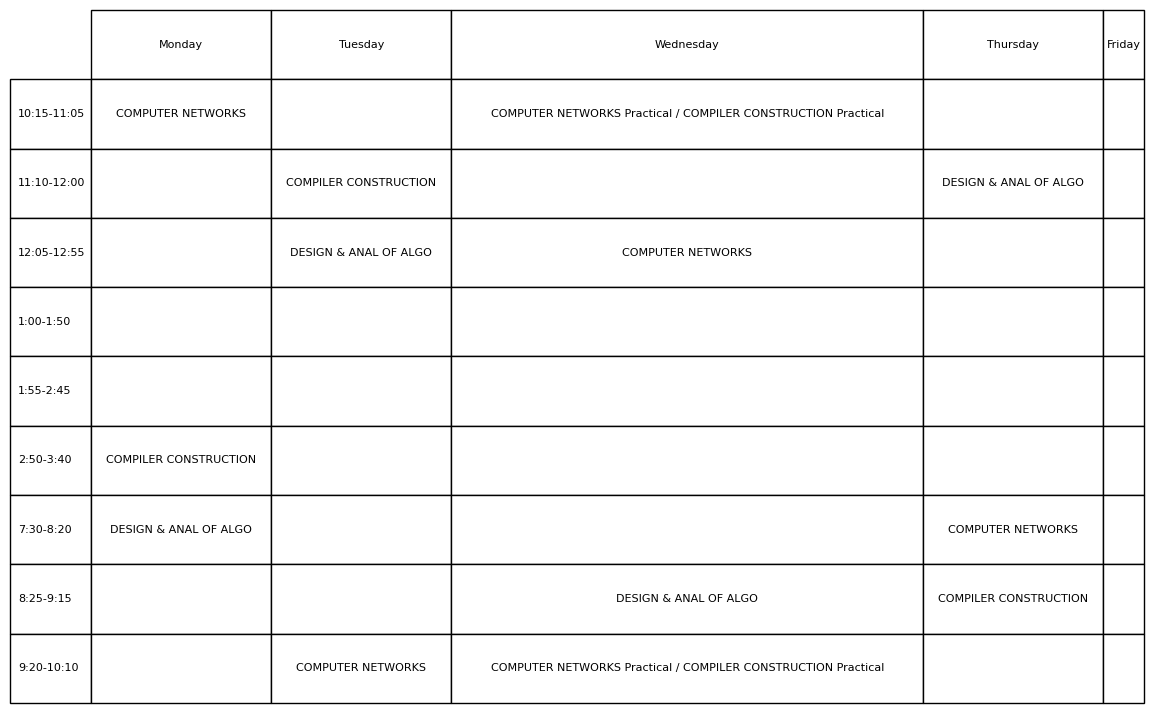

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Provided time slots and days
time_slots = {
    'Monday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00', '12:05-12:55', '1:00-1:50', '1:55-2:45', '2:50-3:40'],
    'Tuesday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00', '12:05-12:55', '1:00-1:50', '1:55-2:45', '2:50-3:40'],
    'Wednesday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00', '12:05-12:55', '1:00-1:50', '1:55-2:45', '2:50-3:40'],
    'Thursday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00', '12:05-12:55', '1:00-1:50', '1:55-2:45', '2:50-3:40'],
    'Friday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00']
}

matches = pd.DataFrame(matches[['COURSE TITLE', 'TIME SLOTS']])

# Creating a dictionary to map (day, time slot) to course titles
course_map = {}
for idx, row in matches.iterrows():
    for day_time in row['TIME SLOTS']:
        day, time = day_time
        if (day, time) not in course_map:
            course_map[(day, time)] = row['COURSE TITLE']
        else:
            course_map[(day, time)] += " / " + row['COURSE TITLE']

num_days = len(time_slots)
max_slots = max(len(slots) for slots in time_slots.values())
timetable = np.full((num_days, max_slots), '', dtype=object)

days_list = list(time_slots.keys())
all_slots = set(slot for day_slots in time_slots.values() for slot in day_slots)
slots_list = sorted(all_slots)

# Filling the timetable with course titles
for day_idx, (day, slots) in enumerate(time_slots.items()):
    for slot_idx, slot in enumerate(slots_list):
        if (day, slot) in course_map:
            timetable[day_idx, slot_idx] = course_map[(day, slot)]
        else:
            timetable[day_idx, slot_idx] = ''

timetable_transposed = timetable.T

# Plotting the timetable
fig, ax = plt.subplots(figsize=(12, 9))  # Adjust figure size as needed
ax.set_axis_off()

table = ax.table(
    cellText=timetable_transposed,
    rowLabels=slots_list,
    colLabels=days_list,
    cellLoc='center',
    loc='center'
)

# Adjust font size
table.set_fontsize(8)

# Dynamically adjust cell width and height
max_text_length = max(len(str(cell)) for row in timetable_transposed for cell in row)
cell_width = max(0.1, min(0.2, 0.005 * max_text_length))
cell_height = 0.05

table.auto_set_column_width(col=list(range(len(days_list))))
for key, cell in table.get_celld().items():
    cell.set_height(cell_height)
    cell.set_width(cell_width)

table.scale(1, 2)
plt.show()


In [41]:
df_timetable = pd.DataFrame(timetable_transposed, columns=days_list, index=slots_list)

df_timetable.to_csv('timetable.csv', index=True)

# Debugging + FINAL ADJUSTMENTS

In [58]:
def clean_course_title(title):
    words = title.split()
    if 'Practical' in words:
        while words.count('Practical') > 1:
            words.remove('Practical')
        return ' '.join(words)
    else:
        return title

compulsory_df = df[df['COURSE NO.'].isin(third_year_second_semester_requirements)]
compulsory_df.reset_index(drop=True, inplace=True)
for index, row in compulsory_df.iterrows():
    if index == 0:  # Skip the first row
        continue
    
    if row['COURSE TITLE'] == 'Practical':
        prev_course_title = compulsory_df.at[index - 1, 'COURSE TITLE']
        compulsory_df.at[index, 'COURSE TITLE'] = prev_course_title + ' Practical'

compulsory_df['COURSE TITLE'] = compulsory_df.apply(lambda row: clean_course_title(row['COURSE TITLE']), axis=1)
compulsory_df

/var/folders/z1/0b4fr5_n0fg0z6szcfq9km100000gn/T/ipykernel_35706/3254796550.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compulsory_df['COURSE TITLE'] = compulsory_df.apply(lambda row: clean_course_title(row['COURSE TITLE']), axis=1)


,COURSE NO.,COURSE TITLE,CREDIT\rL P U,SEC,INSTRUCTOR-IN-CHARGE/ Instructor,ROOM,DAYS/ HOURS,MIDSEM TEST,COMRE DATE &\rSESSION,TIME SLOTS
0,CS F303,COMPUTER NETWORKS,3 1 4,1,PRANAV MOTABHAU PAWAR,269.0,M4 T3 W6 Th1,01.04.2024 AN,31.05.2024 FN,"[(Monday, 10:15-11:05), (Tuesday, 9:20-10:10),..."
1,CS F303,COMPUTER NETWORKS,3 1 4,2,Tamilarasan Periasamy,268.0,M4 W6 Th1 F2,NaN,NaN,"[(Monday, 10:15-11:05), (Wednesday, 12:05-12:5..."
2,CS F303,COMPUTER NETWORKS,3 1 4,3,Raja M,267.0,M4 T9 W6 Th1,NaN,NaN,"[(Monday, 10:15-11:05), (Tuesday, 2:50-3:40), ..."
3,CS F303,COMPUTER NETWORKS Practical,3 1 4,1,Tamilarasan Periasamy,335.0,W34,NaN,NaN,"[(Wednesday, 9:20-10:10), (Wednesday, 10:15-11..."
4,CS F303,COMPUTER NETWORKS Practical,3 1 4,2,Pranav Motabhau Pawar,335.0,Th89,NaN,NaN,"[(Thursday, 1:55-2:45), (Thursday, 2:50-3:40)]"
5,CS F303,COMPUTER NETWORKS Practical,3 1 4,3,Raja M,335.0,F34,NaN,NaN,"[(Friday, 9:20-10:10), (Friday, 10:15-11:05)]"
6,CS F363,COMPILER CONSTRUCTION,2 1 3,1,ELAKKIYA RAJASEKAR,269.0,M9 T5 Th2,29.03.2024 FN,29.05.2024 AN,"[(Monday, 2:50-3:40), (Tuesday, 11:10-12:00), ..."
7,CS F363,COMPILER CONSTRUCTION,2 1 3,2,Angel Arul Jothi,268.0,M3 T5 W9,NaN,NaN,"[(Monday, 9:20-10:10), (Tuesday, 11:10-12:00),..."
8,CS F363,COMPILER CONSTRUCTION,2 1 3,3,Elakkiya Rajasekar,267.0,T3 Th4 F2,NaN,NaN,"[(Tuesday, 9:20-10:10), (Thursday, 10:15-11:05..."
9,CS F363,COMPILER CONSTRUCTION Practical,2 1 3,1,Elakkiya Rajasekar,333.0,W34,NaN,NaN,"[(Wednesday, 9:20-10:10), (Wednesday, 10:15-11..."


In [60]:
from constraint import Problem

problem = Problem()

course_sections = {}  # Dictionary to hold course IDs and their section details

for _, row in compulsory_df.iterrows():
    course_id = row['COURSE TITLE']
    section = row['SEC']
    time_slots = row['TIME SLOTS']  # Assuming list of tuples like ('Monday', '10:15-11:05')

    if course_id not in course_sections:
        course_sections[course_id] = []

    # Each section is uniquely identified by its section number and includes its time slots
    course_sections[course_id].append((section, time_slots))

# Adding each course and its sections to the problem
for course_id, sections in course_sections.items():
    problem.addVariable(course_id, sections)


def no_overlap(section1, section2):
    times1 = section1[1]  # Time slots of the first section
    times2 = section2[1]  # Time slots of the second section
    for day1, time_range1 in times1:
        for day2, time_range2 in times2:
            if day1 == day2:
                start1, end1 = [int(t.replace(':', '')) for t in time_range1.split('-')]
                start2, end2 = [int(t.replace(':', '')) for t in time_range2.split('-')]
                if not (end1 <= start2 or start1 >= end2):
                    return False
    return True


def all_courses_no_overlap(*sections):
    # Sections will be a list of tuples (section_number, time_slots)
    for i in range(len(sections)):
        for j in range(i + 1, len(sections)):
            if not no_overlap(sections[i], sections[j]):
                return False
    return True

# Adding this constraint
problem.addConstraint(all_courses_no_overlap, list(course_sections.keys()))


solution = problem.getSolution()

if solution:
    print(solution)
else:
    print("No possible schedule found that satisfies all constraints.")


{'COMPILER CONSTRUCTION': (3, [('Tuesday', '9:20-10:10'), ('Thursday', '10:15-11:05'), ('Friday', '8:25-9:15')]), 'COMPILER CONSTRUCTION Practical': (3, [('Friday', '9:20-10:10'), ('Friday', '10:15-11:05')]), 'COMPUTER NETWORKS': (3, [('Monday', '10:15-11:05'), ('Tuesday', '2:50-3:40'), ('Wednesday', '12:05-12:55'), ('Thursday', '7:30-8:20')]), 'COMPUTER NETWORKS Practical': (2, [('Thursday', '1:55-2:45'), ('Thursday', '2:50-3:40')]), 'DESIGN & ANAL OF ALGO': (3, [('Monday', '9:20-10:10'), ('Tuesday', '1:55-2:45'), ('Wednesday', '2:50-3:40'), ('Thursday', '9:20-10:10')])}


In [62]:
solution

{'COMPILER CONSTRUCTION': (3,
  [('Tuesday', '9:20-10:10'),
   ('Thursday', '10:15-11:05'),
   ('Friday', '8:25-9:15')]),
 'COMPILER CONSTRUCTION Practical': (3,
  [('Friday', '9:20-10:10'), ('Friday', '10:15-11:05')]),
 'COMPUTER NETWORKS': (3,
  [('Monday', '10:15-11:05'),
   ('Tuesday', '2:50-3:40'),
   ('Wednesday', '12:05-12:55'),
   ('Thursday', '7:30-8:20')]),
 'COMPUTER NETWORKS Practical': (2,
  [('Thursday', '1:55-2:45'), ('Thursday', '2:50-3:40')]),
 'DESIGN & ANAL OF ALGO': (3,
  [('Monday', '9:20-10:10'),
   ('Tuesday', '1:55-2:45'),
   ('Wednesday', '2:50-3:40'),
   ('Thursday', '9:20-10:10')])}

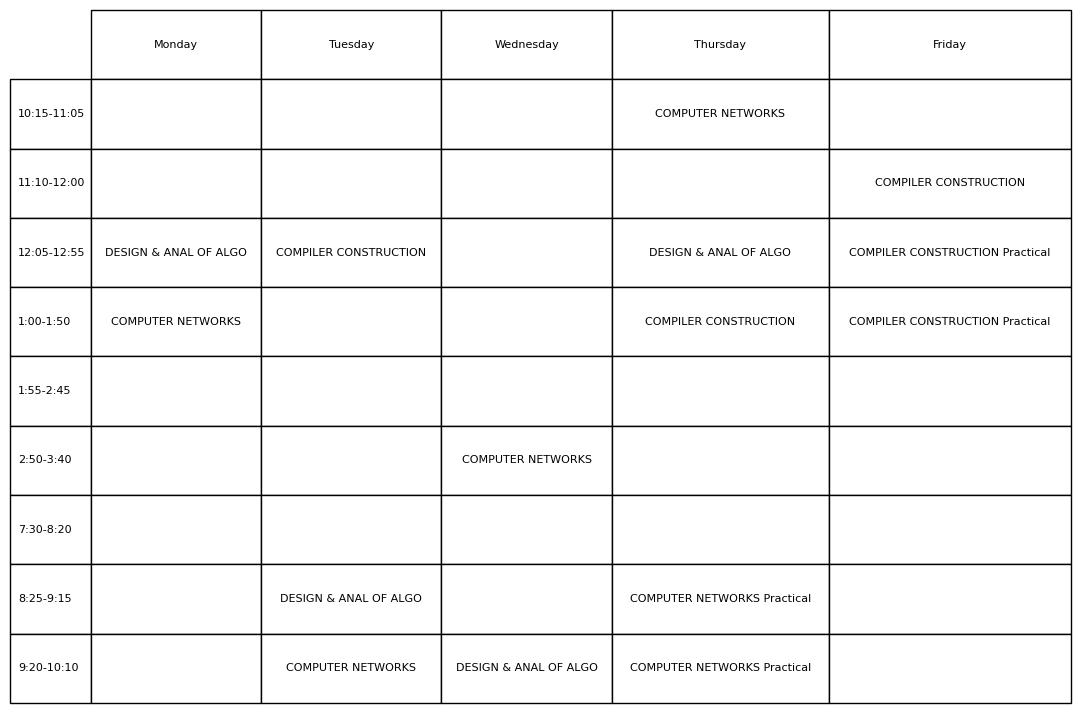

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Provided time slots and days
time_slots = {
    'Monday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00', '12:05-12:55', '1:00-1:50', '1:55-2:45', '2:50-3:40'],
    'Tuesday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00', '12:05-12:55', '1:00-1:50', '1:55-2:45', '2:50-3:40'],
    'Wednesday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00', '12:05-12:55', '1:00-1:50', '1:55-2:45', '2:50-3:40'],
    'Thursday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00', '12:05-12:55', '1:00-1:50', '1:55-2:45', '2:50-3:40'],
    'Friday': ['7:30-8:20', '8:25-9:15', '9:20-10:10', '10:15-11:05', '11:10-12:00']
}

# Creating a dictionary to map (day, time slot) to course titles from the solution
course_map = {}
for course, details in solution.items():
    section, times = details
    for day_time in times:
        day, time = day_time
        if (day, time) not in course_map:
            course_map[(day, time)] = course
        else:
            course_map[(day, time)] += " / " + course

num_days = len(time_slots)
max_slots = max(len(slots) for slots in time_slots.values())
timetable = np.full((num_days, max_slots), '', dtype=object)

days_list = list(time_slots.keys())
all_slots = set(slot for day_slots in time_slots.values() for slot in day_slots)
slots_list = sorted(all_slots)

# Filling the timetable with course titles
for day_idx, (day, slots) in enumerate(time_slots.items()):
    for slot_idx, slot in enumerate(slots):
        if (day, slot) in course_map:
            timetable[day_idx, slot_idx] = course_map[(day, slot)]
        else:
            timetable[day_idx, slot_idx] = ''

timetable_transposed = timetable.T

# Plotting the timetable
fig, ax = plt.subplots(figsize=(12, 9))
ax.set_axis_off()

table = ax.table(
    cellText=timetable_transposed,
    rowLabels=slots_list,
    colLabels=days_list,
    cellLoc='center',
    loc='center'
)

# Adjust font size
table.set_fontsize(8)

# Dynamically adjust cell width and height
max_text_length = max(len(str(cell)) for row in timetable_transposed for cell in row)
cell_width = max(0.1, min(0.2, 0.005 * max_text_length))  # Adjust the scaling factor based on your data
cell_height = 0.05  # Adjust the height as needed

table.auto_set_column_width(col=list(range(len(days_list))))  # Automatically adjust column width based on content
for key, cell in table.get_celld().items():
    cell.set_height(cell_height)
    cell.set_width(cell_width)

table.scale(1, 2)  # Scale table size, adjust as necessary
plt.show()

# Course

In [54]:
df

,COURSE NO.,COURSE TITLE,CREDIT\rL P U,SEC,INSTRUCTOR-IN-CHARGE/ Instructor,ROOM,DAYS/ HOURS,MIDSEM TEST,COMRE DATE &\rSESSION
0,AN F311,PRINCIPLES OF AERODYNAMICS,3 0 3,1,MAJID H KHAN,276,M6 T2 F1,03.04.2024 FN,04.06.2024 AN
2,BIO F110,BIOLOGY LABORATORY,0 2 1,1,Aditya Sharma,307,M34,NaN,NaN
3,BIO F110,BIOLOGY LABORATORY,0 2 1,2,Neeru Sood,307,M89,NaN,NaN
4,BIO F110,BIOLOGY LABORATORY,0 2 1,3,Debostuti Ghosh,307,T34,NaN,NaN
5,BIO F110,BIOLOGY LABORATORY,0 2 1,4,Neeru Sood,307,W12,NaN,NaN
...,...,...,...,...,...,...,...,...,...
305,PHY F110,PHYSICS LABORATORY,0 2 1,8,Amarnath,309.0,Th89,NaN,NaN
306,PHY F111,MECH OSCILLATIONS & WAVE,3 0 3,1,AMARNATH,165.0,M6 T1 Th6 F2,01.04.2024 FN,04.06.2024 FN
307,PHY F111,MECH OSCILLATIONS & WAVE,3 0 3,2,R Roopkumar,183.0,M6 T1 Th6 F2,NaN,NaN
308,PHY F111,MECH OSCILLATIONS & WAVE,3 0 3,3,K K Singh,190.0,M6 T8 W1 F2,NaN,NaN


In [33]:
# Compulsory Courses
 
bio_sem = {
(1, 1, 'BIO F110'),
(1, 1, 'BIO F111'),
(1, 1, 'BITS F110'),
(1, 1, 'BITS F112'),
(1, 1, 'CHEM F110'),
(1, 1, 'CHEM F111'),
(1, 1, 'CS F111'),
(1, 1, 'MATH F111')
}

thermo_sem = {
(1, 2, 'BITS F111'),
(1, 2, 'EEE F111'),
(1, 2, 'MATH F112'),
(1, 2, 'MATH F113'),
(1, 2, 'ME F112'),
(1, 2, 'PHY F110'),
(1, 2, 'PHY F111')
}

second_year_first_semester_requirements = {
(2, 1, 'CS F213'),
(2, 1, 'CS F214'),
(2, 1, 'CS F215'),
(2, 1, 'CS F222'),
(2, 1, 'MATH F21')
}

second_year_second_semester_requirements = {
(2, 2, 'BITS F225'),
(2, 2, 'CS F211'),
(2, 2, 'CS F212'),
(2, 2, 'CS F241')
}

third_year_first_semester_requirements = {
(3, 1, 'CS F301'),
(3, 1, 'CS F342'),
(3, 1, 'CS F351'),
(3, 1, 'CS F372')
}

third_year_second_semester_requirements = {
(3, 2, 'CS F303'),
(3, 2, 'CS F363'),
(3, 2, 'CS F364')
}

In [ ]:
from constraint import Problem

def timetable_generator_with_time_slots(df, year, semester):
    problem = Problem()

    # Define time slots for each day
    time_slots = {
    'Monday': list(range(1, 10)),
    'Tuesday': list(range(1, 10)),
    'Wednesday': list(range(1, 10)),
    'Thursday': list(range(1, 10)),
    'Friday': list(range(1, 6)),
    }   
    
    # Define courses based on year and semester
    course_requirements = {
        (1, 1, 'BIO F110'),
        (1, 1, 'BIO F111'),
        (1, 1, 'BITS F110'),
        (1, 1, 'BITS F112'),
        (1, 1, 'CHEM F110'),
        (1, 1, 'CHEM F111'),
        (1, 1, 'CS F111'),
        (1, 1, 'MATH F111'),
        (1, 2, 'BITS F111'),
        (1, 2, 'EEE F111'),
        (1, 2, 'MATH F112'),
        (1, 2, 'MATH F113'),
        (1, 2, 'ME F112'),
        (1, 2, 'PHY F110'),
        (1, 2, 'PHY F111')
    }
    
    courses = course_requirements.get((year, semester), [])
    
    
    for course in courses:
        problem.addVariable(course, time_slots.values())

    for day, slots in time_slots.items():
        for i, slot in enumerate(slots):
            for other_slot in slots[i + 1:]:
                problem.addConstraint(lambda slot1, slot2: slot1 != slot2, (slot, other_slot))

    solutions = problem.getSolutions()
    
    return solutions

year = 1
semester = '2'
solutions = timetable_generator_with_time_slots(df, year, semester)
for solution in solutions:
    print(solution)